# Using Pandas instead of SQL to load and manipulate data

Based on the kaggle kernels, it seems that pandas can just load in the data directy, it isn't a gigantic dataload.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

orders = pd.read_csv('orders.csv', dtype={'order_id':'int32', 
                                                               'user_id':'int32',
                                                               'eval_set':'category', 
                                                               'order_dow':'category',
                                                               'order_number':'float32',
                                                               'order_hour_of_day':'category', #could also be category
                                                               'days_since_prior_order':'float32'})
products = pd.read_csv('products.csv', dtype={'product_id':'int32', 
                                                                   'product_name':'object', 
                                                                   'aisle_id':'int16', 
                                                                   'department_id':'int16'})
order_products_train = pd.read_csv('order_products__train.csv', dtype={'order_id':'int32',
                                                                                     'product_id':'int32',
                                                                                     'add_to_cart_order':'int8',
                                                                                     'reordered':'uint8'})
order_products_prior = pd.read_csv('order_products__prior.csv', dtype={'order_id':'int32',
                                                                                     'product_id':'int32',
                                                                                     'add_to_cart_order':'int8',
                                                                                     'reordered':'uint8'})
aisles = pd.read_csv('aisles.csv', dtype={'aisle_id':'int16', 'aisle':'category'})
departments = pd.read_csv('departments.csv', dtype={'department_id':'int8', 'department':'category'})

## Merge orders and products to create data sets

In [2]:
prior_order=order_products_prior.merge(orders,on='order_id')
train_order=order_products_train.merge(orders,on='order_id')
test_order=orders[orders.eval_set=='test']
# prior_order=prior_order.merge(products,on='product_id')
# train_order=train_order.merge(products,on='product_id')

Split the data into features and labes

In [3]:
prior_order.replace([np.inf, -np.inf], np.nan)
prior_order.dropna(axis=0,how='any',inplace=True)
label=prior_order.reordered
features=prior_order.drop(['reordered','eval_set'],axis=1)

In [20]:
train_label=train_order.reordered
train_feat=train_order.drop(['reordered','eval_set'],axis=1)

In [4]:
features.columns.values

array(['order_id', 'product_id', 'add_to_cart_order', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'], dtype=object)

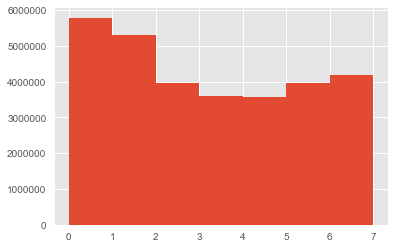

In [5]:
plt.hist(features.order_dow.astype('int8'),bins=np.arange(8))
plt.show()

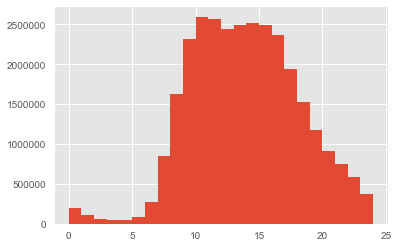

In [6]:
plt.hist(features.order_hour_of_day.astype('int8'),bins=np.arange(25))
plt.show()

<function matplotlib.pyplot.show>

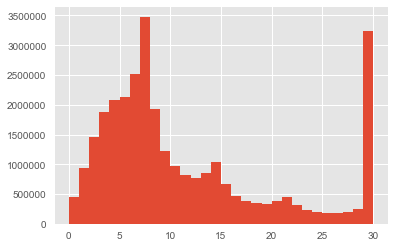

In [7]:
plt.hist(features.days_since_prior_order.astype('int8'),bins=np.arange(31))
plt.show

<function matplotlib.pyplot.show>

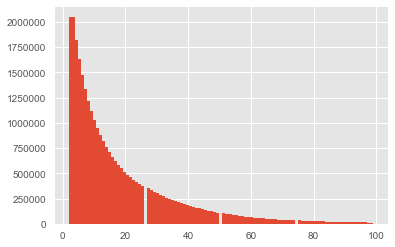

In [8]:
plt.hist(features.order_number,bins=101)
plt.show

Normalize data

I figure that the days since last order and number of orders have a continous relational meaning (larger numbers mean something in relation to smaller numbers), they can be kept as continuous variables


In [9]:
# from sklearn.preprocessing import MinMaxScaler

# # Initialize a scaler, then apply it to the features
# scaler = MinMaxScaler()
# numerical = ['order_dow','order_hour_of_day','days_since_prior_order','order_number']
# features[numerical] = scaler.fit_transform(prior_order[numerical].dropna(how='any'))
features.days_since_prior_order=np.divide(features.days_since_prior_order,30.0)
features.order_number=np.divide(features.order_number,100.0)

In [21]:
train_feat.days_since_prior_order=np.divide(train_feat.days_since_prior_order,30.0)
train_feat.order_number=np.divide(train_feat.order_number,100.0)

<function matplotlib.pyplot.show>

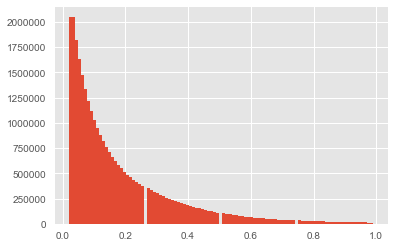

In [10]:
plt.hist(features.order_number,bins=101)
plt.show

<function matplotlib.pyplot.show>

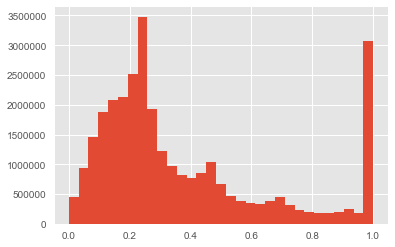

In [11]:
plt.hist(features.days_since_prior_order,bins=31)
plt.show

shuffle and split data

design performance metric

One Hot Encode categoricals

This run excludes users as a variable, however that would be crucial if I wanted user specific recommendations

In [12]:
features = pd.get_dummies(features)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))
print (encoded)

37 total features after one-hot encoding.
['order_id', 'product_id', 'add_to_cart_order', 'user_id', 'order_number', 'days_since_prior_order', 'order_dow_0', 'order_dow_1', 'order_dow_2', 'order_dow_3', 'order_dow_4', 'order_dow_5', 'order_dow_6', 'order_hour_of_day_00', 'order_hour_of_day_01', 'order_hour_of_day_02', 'order_hour_of_day_03', 'order_hour_of_day_04', 'order_hour_of_day_05', 'order_hour_of_day_06', 'order_hour_of_day_07', 'order_hour_of_day_08', 'order_hour_of_day_09', 'order_hour_of_day_10', 'order_hour_of_day_11', 'order_hour_of_day_12', 'order_hour_of_day_13', 'order_hour_of_day_14', 'order_hour_of_day_15', 'order_hour_of_day_16', 'order_hour_of_day_17', 'order_hour_of_day_18', 'order_hour_of_day_19', 'order_hour_of_day_20', 'order_hour_of_day_21', 'order_hour_of_day_22', 'order_hour_of_day_23']


In [22]:
train_feat = pd.get_dummies(train_feat)

In [13]:
max(features.user_id)

206209

In [14]:
from sklearn.model_selection import train_test_split #sklearn 0.18.1 and up
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 24285136 samples.
Testing set has 6071285 samples.


In [26]:
from sklearn.metrics import f1_score, accuracy_score
import time
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
#     start = time() # Get start time
    learner = clf.fit(X_train.sample(n=sample_size,random_state=1),y_train.sample(n=sample_size,random_state=1)) #df.sample(frac=percent) maybe too?
#     end = time() # Get end time
    
    # TODO: Calculate the training time
#     results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
#     start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
#     end = time() # Get end time
    
    # TODO: Calculate the total prediction time
#     results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = f1_score(y_train[:300],predictions_train)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = f1_score(y_test,predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [27]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import time
# Initialize
clf = AdaBoostClassifier(random_state=2)
# clf = DecisionTreeClassifier(random_state=2)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = len(y_train.sample(frac=.01))
samples_10 = len(y_train.sample(frac=.1))
samples_100 = len(y_train.sample(frac=1))

# Collect results on the learners
results = {}

# clf_name = DecisionTreeClassifier(random_state=2)
train_predict(clf, samples_1, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
# vs.evaluate(results, accuracy, fscore)

AdaBoostClassifier trained on 242851 samples.


{'acc_test': 0.69687949091502044,
 'acc_train': 0.73333333333333328,
 'f_test': 0.78201140514931489,
 'f_train': 0.8130841121495328}

In [17]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
##resubmit - initialized random state and passed in fbeta scorer into GridSearchCV. Also probed lower number for max depth.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# TODO: Initialize the classifier
# clf = AdaBoostClassifier(random_state=2)

# TODO: Create the parameters list you wish to tune
parameters = {'base_estimator__max_depth':(1,2,None),
              'base_estimator__min_samples_split':(10,50,100),
              'learning_rate':(.1,1),
              'n_estimators':(75,100,150)}


sample_size = len(y_train.sample(frac=.001))

base = DecisionTreeClassifier(random_state = 2)

clf = AdaBoostClassifier(base_estimator = base)

# run grid search

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(f1_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,param_grid=parameters,n_jobs=-1,scorer=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train.sample(n=sample_size,random_state=1),y_train.sample(n=sample_size,random_state=1))

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train.sample(n=sample_size,random_state=1), y_train.sample(n=sample_size,random_state=1))).predict(X_test)
best_predictions = best_clf.predict(X_test)
# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
# print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
# print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.5953

Optimized Model
------
Final accuracy score on the testing data: 0.6975


In [28]:
sample_size = len(y_train.sample(frac=.01))
best_clf.fit(features.sample(n=sample_size,random_state=1), label.sample(n=sample_size,random_state=1))

optipredict=best_clf.predict(train_feat)

print(f1_score(train_label, optipredict))
             
             
             

0.754306287347


## Save out the optimized algorithm

Saves algorithm 

In [29]:
from sklearn.externals import joblib
joblib.dump(best_clf, 'optimal_adaboost.pkl') 

['optimal_adaboost.pkl']

<function matplotlib.pyplot.show>

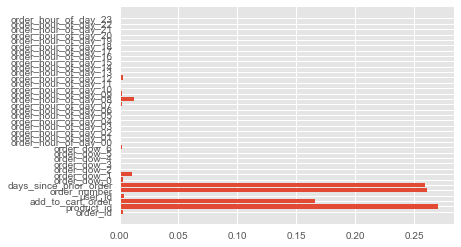

In [46]:
importances = best_clf.feature_importances_
y_pos=np.arange(len(features.columns))
plt.barh(y_pos,importances)
plt.yticks(y_pos,features.columns)
plt.show


Looks like day of week and hour of order pretty much don't matter - potentially people only use instacart for single purpose (order single meal items, get weekly groceries, crave ordering), not often multiple purpose. overwhelmingly, the product, the time since prior order, and the order number are important for determining reorders.

In [ ]:
submission=pd.DataFrame()
submission['order_id']=train_order.order_id